# GECCO2019 - Bi-objective Traveling Thief Problem 

This worksheet contains the evaluation for the competition at **GECCO2019**. 
After having received all submissions, the evaluation will be done as follows:

After having received all submissions, the evaluation will be done as follows:

For each of the nine test problems

a) We will merge the solution sets of all submissions and extract the non-dominated set.

b) The minimum in time and the maximum in profit will be used to determine the reference point.

c) With respect to this reference point the quality of each submission will be measured using the hypervolume indicator.

d) We will sort the submissions according to the achieved hypervolume in descending order and give points as follows: 1st place -> 3 points, 2nd place -> 2 points, 3rd place -> 1 point.


By adding up the points for each submission we will create the overall ranking. Please note, that depending on the number of submissions the evaluation might need to be reconsidered.

The validation has already been done using the Java code. Which means that each submission has the correct number of solutions (less than the maximum specfied at the competition homepage).


## Imports necessary for the evaluation

In [121]:
from non_dominated_sorting import fast_non_dominated_sort
import os.path
import numpy as np
import matplotlib.pyplot as plt
from hv import Hypervolume
from normalization import normalize
import pandas as pd

## Participants and Problems

In [122]:
# the result folder as a path
folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "submissions")



# all submissions received
participants = ["MY-TEAM"
    #"ALLAOUI","jomar", "shisunzhang",  "faria", "HPI",
                #"NTGA", "SSteam", "SamirO-ETF-ba", "FRA", "sinc", "JG",
                 # "ValAurTeam", "MicroGA" ## unfortunatly those submissions were invalid  
               ]


# all the problems to be solved
problems = ["a280_n279"]
#, "a280_n1395", "a280_n2790","fnl4461_n4460", "fnl4461_n22300", "fnl4461_n44600", "pla33810_n33809", "pla33810_n169045", "pla33810_n338090"

## Load data

Load all data from the submission directory and convert it to a minimization problem.
The data dictionary contains all submissions of a participant. The set of non-dominated points
is converted to a minimization problem by multiplying the profit times -1.

In [123]:

data = {}

for problem in problems:
    _entry = {}
    for participant in participants:
        
        # check for the corresponding file
        fname = "%s_%s.f" % (participant, problem)   
        path_to_file = os.path.join(folder,participant, fname)
        
        # in case the wrong delimiter was used
        if not os.path.isfile(path_to_file):
            fname = "%s_%s.f" % (participant, problem.replace("_", "-"))
            path_to_file = os.path.join(folder,participant, fname)
         
        # load the values in the objective space - first column is time, second profit
        _F = np.loadtxt(path_to_file)
        
        # modify it to a min-min problem by multiplying the profit by -1
        _entry[participant] = _F * [1, -1]
        
    data[problem] = _entry




## Plot the results

To get an idea how the submissions look like, we are plotting the results first.
Note that the plots are not normalized yet and the ranges of both object vary.

Plot the results. If points are not shown there are not in the non-dominated region.
a280_n279


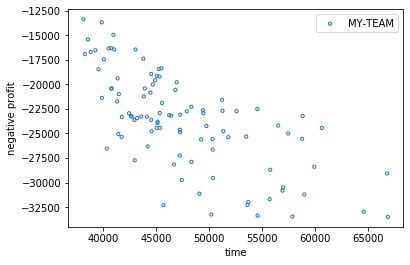

In [124]:
print("Plot the results. If points are not shown there are not in the non-dominated region.")

import matplotlib.cm as cm
cmap = cm.get_cmap('tab20')

only_top_3 = False

for problem in problems:
    
    for k, participant in enumerate(participants):
        
        if not only_top_3 or (only_top_3 and participant in ["HPI", "jomar", "NTGA"]):

            _F = data[problem][participant]
            plt.scatter(_F[:,0], _F[:,1], label=participant, s=10, facecolors='none', edgecolors=cmap(k))

    _all = np.row_stack([data[problem][participant] for participant in participants])
    I = fast_non_dominated_sort(_all)[0]
    _non_dom = _all[I]
    
    _min = _non_dom.min(axis=0)
    _max = _non_dom.max(axis=0)
    _range = _max - _min
        
    print("=" * 60)
    print(problem)
    print("=" * 60)
    plt.xlabel("time")
    plt.ylabel("negative profit")
    plt.xlim(_min[0] - 0.05 * _range[0], _max[0] + 0.05 * _range[0])
    plt.ylim(_min[1] - 0.05 * _range[1], _max[1] + 0.05 * _range[1])
    plt.legend()
    plt.show()
        

## Find the reference non-dominated set for each test instance

For each problem we merge the submissions to a new population and filter out the non-dominated solutions. Then, we take the minimum and the maximum of this set as the ideal and nadir point the normalize the results.

In [125]:

ideal_point = {}
nadir_point = {}
ndf = {}

for problem in problems:
    
    # the merged non-dominated solutions for the specific problem
    M = []
    for participant in participants:    
        _F = data[problem][participant]
        M.append(_F)
        
    M = np.vstack(M)    
    I = fast_non_dominated_sort(M)[0]
    M = M[I, :]
    
    ideal_point[problem] = np.min(M, axis=0)
    nadir_point[problem] = np.max(M, axis=0)
    ndf[problem] = M
    
    

In the following for each problem the non-dominated set of solutions is first normalized using the boundaries and hypervolume is calculated.

In [126]:
results = []

for problem in problems:
    
    z = ideal_point[problem]
    z_nad = nadir_point[problem]
 
    for participant in participants:    
        _F = data[problem][participant]
        _N = normalize(_F, z, z_nad)
        _hv = Hypervolume(np.array([1,1])).calc(_N)
        results.append({'problem' : problem, 'participant' : participant, 'hv' : _hv})
        
df = pd.DataFrame(results, columns=["problem", "participant", "hv"])


In [127]:
for problem in problems:

    print("=" * 60)
    print(problem)
    print("=" * 60)
    
    _df = df[df["problem"] == problem].copy()
    _df.sort_values("hv", ascending=False, inplace=True)
    _df.reset_index(drop=True, inplace=True)
    print(_df)

a280_n279
     problem participant        hv
0  a280_n279     MY-TEAM  0.868947


The data frame contains all results. Now, we need to rank the submission for each test instance:

In [56]:
# the final ranking. And add zero points initially (sum is later taken anyway...)
ranking = []
for participant in participants:
    ranking.append({'participant': participant, 'points' : 0})


# one more time loop through problem wise
for problem in problems:
    
    _df = df[df["problem"] == problem].copy()
    
    # sort descending by hv
    _df.sort_values("hv", ascending=False, inplace=True)
    
    # 3 points for the 1st place
    first = _df.iloc[0]["participant"]
    ranking.append({'participant': first, 'points' : 3})
    
    # 2 points for the 2nd place
    #second = _df.iloc[1]["participant"]
    #ranking.append({'participant': second, 'points' : 2})
    
    # 1 point for the 3rd place
    #third = _df.iloc[2]["participant"]
    #ranking.append({'participant': third, 'points' : 1})

    
ranking = pd.DataFrame(ranking, columns=["participant", "points"])

# Leaderboard

Finally, we sum up the hypervolume for each problem and evaluate the winner!

In [48]:
ranking.groupby('participant').sum().sort_values("points", ascending=False)

,points
participant,
MY-TEAM,3


## Leaderboard as HTML

In [13]:


standalone = True
if standalone:
    print("<script src='https://code.jquery.com/jquery-3.2.1.slim.min.js' integrity='sha384-KJ3o2DKtIkvYIK3UENzmM7KCkRr/rE9/Qpg6aAZGJwFDMVNA/GpGFF93hXpG5KkN' crossorigin='anonymous'></script>")
    print("<script src='https://cdnjs.cloudflare.com/ajax/libs/popper.js/1.12.9/umd/popper.min.js' integrity='sha384-ApNbgh9B+Y1QKtv3Rn7W3mgPxhU9K/ScQsAP7hUibX39j7fakFPskvXusvfa0b4Q' crossorigin='anonymous'></script>")
    print("<script src='https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/js/bootstrap.min.js' integrity='sha384-JZR6Spejh4U02d8jOt6vLEHfe/JQGiRRSQQxSfFWpi1MquVdAyjUar5+76PVCmYl' crossorigin='anonymous'></script>")

print("<div class='row'><div class='w-50'>")
print("<table class='table'>")
print("<tr><th>Problem</th><th>Team</th><th>Hypervolume</th><th>Estimated Ideal Point</th><th>Estimated Nadir Point</th></tr>")

for problem in problems:
    
    _df = df[df["problem"] == problem].copy()
    _df.sort_values("hv", ascending=False, inplace=True)
    _df.reset_index(drop=True)
    
    first = True
    for i, e in _df.iterrows():
        
        problem, team, hv = e.values
        
        if first:
            
            s_row_span = "<th rowspan='%s'>%s</th>"
            
            s_problem = s_row_span % (len(_df), problem)
            s_ideal = s_row_span % (len(_df), "(%s, %s)" % (round(ideal_point[problem][0]), round(ideal_point[problem][1])))
            s_nadir = s_row_span % (len(_df), "(%s, %s)" % (round(nadir_point[problem][0]), round(nadir_point[problem][1])))
            
            print("<tr>%s <th>%s</th> <th>%s</th> %s %s  </tr>" 
                  % (s_problem, team, round(hv,4), s_ideal, s_nadir))
        else:
            print("<tr><th>%s</th><th>%s</th></tr>" % (team, round(hv,4)))
        
            
        first = False
        
    print()
    
    
print("<table>")
print("</div></div>")

<script src='https://code.jquery.com/jquery-3.2.1.slim.min.js' integrity='sha384-KJ3o2DKtIkvYIK3UENzmM7KCkRr/rE9/Qpg6aAZGJwFDMVNA/GpGFF93hXpG5KkN' crossorigin='anonymous'></script>
<script src='https://cdnjs.cloudflare.com/ajax/libs/popper.js/1.12.9/umd/popper.min.js' integrity='sha384-ApNbgh9B+Y1QKtv3Rn7W3mgPxhU9K/ScQsAP7hUibX39j7fakFPskvXusvfa0b4Q' crossorigin='anonymous'></script>
<script src='https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/js/bootstrap.min.js' integrity='sha384-JZR6Spejh4U02d8jOt6vLEHfe/JQGiRRSQQxSfFWpi1MquVdAyjUar5+76PVCmYl' crossorigin='anonymous'></script>
<div class='row'><div class='w-50'>
<table class='table'>
<tr><th>Problem</th><th>Team</th><th>Hypervolume</th><th>Estimated Ideal Point</th><th>Estimated Nadir Point</th></tr>
<tr><th rowspan='1'>a280_n279</th> <th>MY-TEAM</th> <th>0.7233</th> <th rowspan='1'>(34354.0, -32735.0)</th> <th rowspan='1'>(110114.0, -0.0)</th>  </tr>

<table>
</div></div>


In [14]:
_ranking = ranking.groupby('participant').sum().sort_values("points", ascending=False)

standalone = True
if standalone:
    print("<script src='https://code.jquery.com/jquery-3.2.1.slim.min.js' integrity='sha384-KJ3o2DKtIkvYIK3UENzmM7KCkRr/rE9/Qpg6aAZGJwFDMVNA/GpGFF93hXpG5KkN' crossorigin='anonymous'></script>")
    print("<script src='https://cdnjs.cloudflare.com/ajax/libs/popper.js/1.12.9/umd/popper.min.js' integrity='sha384-ApNbgh9B+Y1QKtv3Rn7W3mgPxhU9K/ScQsAP7hUibX39j7fakFPskvXusvfa0b4Q' crossorigin='anonymous'></script>")
    print("<script src='https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/js/bootstrap.min.js' integrity='sha384-JZR6Spejh4U02d8jOt6vLEHfe/JQGiRRSQQxSfFWpi1MquVdAyjUar5+76PVCmYl' crossorigin='anonymous'></script>")


print("<div class='row'><div class='w-50'>")
print("<table class='table'>")
print("<tr><th>Rank</th><th>Team</th><th>Points</th></tr>")


counter = 0
for i, e in _ranking.iterrows():
    print("<tr><th>%s</th><th>%s</th><th>%s</th></tr>" % (counter+1, i, e[0]))
    counter += 1

    
print("<table>")
print("</div></div>")


<script src='https://code.jquery.com/jquery-3.2.1.slim.min.js' integrity='sha384-KJ3o2DKtIkvYIK3UENzmM7KCkRr/rE9/Qpg6aAZGJwFDMVNA/GpGFF93hXpG5KkN' crossorigin='anonymous'></script>
<script src='https://cdnjs.cloudflare.com/ajax/libs/popper.js/1.12.9/umd/popper.min.js' integrity='sha384-ApNbgh9B+Y1QKtv3Rn7W3mgPxhU9K/ScQsAP7hUibX39j7fakFPskvXusvfa0b4Q' crossorigin='anonymous'></script>
<script src='https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/js/bootstrap.min.js' integrity='sha384-JZR6Spejh4U02d8jOt6vLEHfe/JQGiRRSQQxSfFWpi1MquVdAyjUar5+76PVCmYl' crossorigin='anonymous'></script>
<div class='row'><div class='w-50'>
<table class='table'>
<tr><th>Rank</th><th>Team</th><th>Points</th></tr>
<tr><th>1</th><th>MY-TEAM</th><th>3</th></tr>
<table>
</div></div>
